### Introduction
Objective of this workbook is to follow the CRISP-DM methodology and explore the OSMI Mental Health in Tech Survey data from 2014 to 2019. 
The data is made availalbe in kaggle at https://www.kaggle.com/anth7310/mental-health-in-the-tech-industry in a sqllitedatabase

Using this dataset the following questions are attempted:

Q1) Are people working in Tech reporting higher mental health issues than non-Tech workers?

Q2) Do people working in smaller organisations have better or worse mental health than those wrking in larger organisations?

Q3) What type of role do people with mental health issues have?



### Stage 1 : Gathering Data

In [2]:
# Data is provided as a sqllite database instance, consisting of 3 tables
import sqlite3
import pandas as pd
# Create connection
cnx = sqlite3.connect('data/mental_health.sqlite')
sql_df_sur = pd.read_sql_query("SELECT * FROM Survey", cnx)
sql_df_ques = pd.read_sql_query("SELECT * FROM Question", cnx)
sql_df_ans = pd.read_sql_query("SELECT * FROM Answer", cnx)

#### Validate the gathered data
##### The Survery Table contains information of the survery years consolidated in the tables. Information only. Can be ignored

In [3]:
sql_df_sur

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


##### Question table contains the Questions and the mapped question id

In [4]:
sql_df_ques

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


##### The survery responses are captured in the Answer table

In [6]:
sql_df_ans

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


### Stage 2: Assessment and enrichment of the data

In [7]:
### Number of users/responses are 4218 starting at 1 and ending at 4218
nusers = sql_df_ans['UserID'].nunique()
nusers, sql_df_ans['UserID'].max()

(4218, 4218)

In [8]:
#Join the question and answer tables
#Rename the column name for joining
sql_df_ques.rename(columns={"questionid": "QuestionID"}, inplace=True)
sql_df_ans=sql_df_ans.join(sql_df_ques.set_index('QuestionID'), on='QuestionID')

In [9]:
# An individual survey response contains responses to a minimum of 26 questions, maximum of 76 questions and an average of about 56 questions out of 105 total questions for a user survey
sql_df_ans.groupby('UserID')['QuestionID'].count().min(), sql_df_ans.groupby('UserID')['QuestionID'].count().max(), sql_df_ans.groupby('UserID')['QuestionID'].count().mean()
# This implies that there are a large number of null entries for a survey response

(26, 76, 56.16358463726885)

In [10]:
# De-duplicate rows, by merging multiple answers for a given question by the user
# Then create a consolidated dataframe for the survey responses, one row for one user response
osmi_df = pd.DataFrame()
# For all users
for user in range(1, nusers+1):
    #Get the responses for the given user and remove unnecessary columns
    temp_df = sql_df_ans[sql_df_ans['UserID']==user].drop(columns=['SurveyID','UserID','questiontext']) 
    dup = temp_df.duplicated(subset='QuestionID')
    dup_q = temp_df[dup]['QuestionID'].values
    #If there are any duplicate entries then de-duplicate them by merging the responses seperated by a ', '
    if dup.sum() > 0:
        for d in dup_q:
            ans = ', '.join(temp_df[temp_df['QuestionID']==d]['AnswerText'].values)
            temp_df.drop(temp_df[temp_df['QuestionID']==d].index, inplace=True)
            temp_df=temp_df.append({'AnswerText': ans, 'QuestionID': d}, ignore_index=True)  
    temp_df['QuestionID'] = temp_df.QuestionID.astype('str')
    #Transpose the dataframe to make the Question ids as features (columns)
    temp_df_T=temp_df.set_index('QuestionID').T.reset_index(drop=True)
    #Add a column to capture the UserID for the response
    temp_df_T.insert(0,'UserID',user)
    temp_df_T.set_index('UserID')
    #Keep adding the responses to the dataframe
    osmi_df = pd.concat([osmi_df,temp_df_T])

In [11]:
# Verify that the dataframe contains 4218 rows (one for each user) and 105 (max responses) + 1 (userid) columns
osmi_df.shape

(4218, 106)

##### Seperating the Categorical & numerical values & removing the descriptive fields
##### 1: 'What is your age?', [Numerical]
##### 2: 'What is your gender?', [Categorical]
##### 3: 'What country do you live in?',[Categorical]
##### 4: 'If you live in the United States, which state or territory do you live in?', [Categorical]
##### 5: 'Are you self-employed?', [Categorical]
##### 6: 'Do you have a family history of mental illness?', [Categorical]
##### 7: 'Have you ever sought treatment for a mental health disorder from a mental health professional?', [Categorical]
##### 8: 'How many employees does your company or organization have?',  [Categorical]
##### 9: 'Is your employer primarily a tech company/organization?', [Categorical]
##### 10: 'Does your employer provide mental health benefits as part of healthcare coverage?', [Categorical]
##### 11: 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?', [Categorical]
##### 12: 'Would you bring up a mental health issue with a potential employer in an interview?', [Categorical]
##### 13: 'Is your primary role within your company related to tech/IT?', [Categorical]
##### 14: 'Do you know the options for mental health care available under your employer-provided health coverage?', [Categorical]
##### 15: 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?', [Categorical]
##### 16: 'Does your employer offer resources to learn more about mental health disorders and options for seeking help?', [Categorical]
##### 17: 'If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?', [Categorical]
##### 18: 'Would you feel comfortable discussing a mental health issue with your coworkers?', [Categorical] 
##### 19: 'Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?', [Categorical]
##### 20: 'Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?', [Categorical]
##### 21: 'Do you know local or online resources to seek help for a mental health issue?', [Categorical]
##### 22: 'Do you have previous employers?', [Categorical]
##### 23: 'Have your previous employers provided mental health benefits?', [Categorical]
##### 24: 'Were you aware of the options for mental health care provided by your previous employers?', [Categorical]
##### 25: 'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?', [Categorical]
##### 26: 'Did your previous employers provide resources to learn more about mental health disorders and how to seek help?', [Categorical]
##### 27: 'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?', [Categorical]
##### 28: 'Would you have been willing to discuss your mental health with your direct supervisor(s)?', [Categorical]
##### 29: 'Would you be willing to bring up a physical health issue with a potential employer in an interview?', [Categorical]
##### 30: 'How willing would you be to share with friends and family that you have a mental illness?', [Categorical]
##### 31: 'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?', [Categorical]
##### 32: 'Have you had a mental health disorder in the past?', [Categorical]
##### 33: 'Do you currently have a mental health disorder?', [Categorical]
##### 34: 'Have you ever been diagnosed with a mental health disorder?', [Categorical]
##### 48: 'If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?', [Categorical]
##### 49: 'If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?', [Categorical]
##### 50: 'What country do you work in?', [Categorical]
##### 51: 'What US state or territory do you work in?', [Categorical]
##### 52: 'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?', [Categorical]
##### 53: 'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?', [Categorical]
##### 54: 'Do you believe your productivity is ever affected by a mental health issue?', [Categorical]
##### 55: 'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?', [Categorical]
##### 56: 'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?', [Categorical]
##### 57: 'Would you feel more comfortable talking to your coworkers about your physical health or your mental health?', [Categorical]
##### 58: 'Have you ever discussed your mental health with your employer?', [Categorical]
##### 59: 'Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.', [Descriptive]
##### 60: 'Have you ever discussed your mental health with coworkers?',  [Categorical]
##### 61: 'Describe the conversation with coworkers you had about your mental health including their reactions.', [Descriptive]
##### 62: "Have you ever had a coworker discuss their or another coworker's mental health with you?", [Categorical]
##### 63: 'Describe the conversation your coworker had with you about their mental health (please do not use names).', [Descriptive]
##### 64: 'Overall, how much importance does your employer place on physical health?', [Categorical]
##### 65: 'Overall, how much importance does your employer place on mental health?', [Categorical]
##### 66: 'If you have revealed a mental health disorder to a client or business contact, how has this affected you or the relationship?', [Categorical]
##### 67: 'If you have revealed a mental health disorder to a coworker or employee, how has this impacted you or the relationship?', [Categorical]
##### 68: 'Was your employer primarily a tech company/organization?', [Categorical]
##### 69: 'Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?', [Categorical]
##### 70: 'Did you ever discuss your mental health with your previous employer?', [Categorical]
##### 71: 'Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.', [Descriptive]
##### 72: 'Did you ever discuss your mental health with a previous coworker(s)?', [Categorical]
##### 73: 'Describe the conversation you had with your previous coworkers about your mental health including their reactions.', [Descriptive]
##### 74: "Did you ever have a previous coworker discuss their or another coworker's mental health with you?", [Categorical]
##### 75: 'Describe the conversation your coworker had with you about their mental health (please do not use names)..1', [Descriptive]
##### 76: 'Overall, how much importance did your previous employer place on physical health?', [Categorical]
##### 77: 'Overall, how much importance did your previous employer place on mental health?', [Categorical]
##### 78: 'Are you openly identified at work as a person with a mental health issue?', [Categorical]
##### 79: 'Has being identified as a person with a mental health issue affected your career?', [Categorical]
##### 80: 'How has it affected your career?', [Categorical]
##### 81: 'If they knew you suffered from a mental health disorder, how do you think that your team members/co-workers would react?', [Categorical]
##### 82: 'Describe the circumstances of the badly handled or unsupportive response.', [Descriptive]
##### 83: 'Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?', [Categorical]
##### 84: 'Describe the circumstances of the supportive or well handled response.', [Descriptive]
##### 85: 'Overall, how well do you think the tech industry supports employees with mental health issues?', [Categorical]
##### 86: 'Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.', [Descriptive]
##### 87: 'If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.', [Descriptive]
##### 88: 'Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used _anonymously_ and only with your permission.)',
##### 89: 'What is your race?', [Categorical]
##### 90: 'Do you think that discussing a physical health issue with your employer would have negative consequences?', [Categorical]
##### 91: 'Do you feel that your employer takes mental health as seriously as physical health?', [Categorical]
##### 92: 'If you have a mental health condition, do you feel that it interferes with your work?', [Categorical]
##### 93: 'Do you work remotely (outside of an office) at least 50% of the time?', [Categorical]
##### 94: 'Do you know the options for mental health care your employer provides?', [Categorical]
##### 95: 'Has your employer ever discussed mental health as part of an employee wellness program?', [Categorical]
##### 96: 'Does your employer provide resources to learn more about mental health issues and how to seek help?', [Categorical]
##### 97: 'How easy is it for you to take medical leave for a mental health condition?', [Categorical]
##### 98: 'Do you think that discussing a mental health issue with your employer would have negative consequences?', [Categorical]
##### 99: 'Would you be willing to discuss a mental health issue with your coworkers?', [Categorical]
##### 100: 'Would you be willing to discuss a mental health issue with your direct supervisor(s)?', [Categorical]
##### 101: 'Would you bring up a physical health issue with a potential employer in an interview?', [Categorical]
##### 102: 'Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?', [Categorical]
##### 103: 'Any additional notes or comments', [Descriptive]
##### 104: 'Do you think that discussing a mental health disorder with your employer would have negative consequences?', [Categorical]
##### 105: 'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?', [Categorical]
##### 106: 'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?', [Categorical]
##### 107: 'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?', [Categorical]
##### 108: 'Do you think that discussing a mental health disorder with previous employers would have negative consequences?', [Categorical]
##### 109: 'Do you think that discussing a physical health issue with previous employers would have negative consequences?', [Categorical]
##### 110: 'Would you have been willing to discuss a mental health issue with your previous co-workers?', [Categorical]
##### 111: 'Did you feel that your previous employers took mental health as seriously as physical health?', [Categorical]
##### 112: 'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?', [Categorical]
##### 113: 'Do you feel that being identified as a person with a mental health issue would hurt your career?', [Categorical]
##### 114: 'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?', [Categorical]
##### 115: 'If yes, what condition(s) have you been diagnosed with?', [Categorical]
##### 116: 'If maybe, what condition(s) do you believe you have?', [Categorical]
##### 117: 'Which of the following best describes your work position?', [Categorical]
##### 118: 'Do you work remotely?' [Categorical]

In [12]:
# Drop the descriptive columns
osmi_df = osmi_df.drop(columns=['59','61','63','71','73','75','82', '84','86','87','103'])

#### How to determine the mental health of the repondents without any explicit markers?

In [13]:
# There are around 30% missing values for people definitively responding to question of whether they have or had any mental health issue
(osmi_df['32'].isna()|osmi_df['33'].isna()).sum()/nusers

0.29871977240398295

In [14]:
# Only 52% people responding clearly as to whether they have or had any mental health issue
((osmi_df['33']=='Yes')| (osmi_df['33']== 'No')).sum()/nusers

0.5229966808914177

#### Instead of classifying a person having a mental health issue or not, I think its better to come up with a score to identify the level of mental health issue a person has. A crude way is to speciofy weights to individual responses to arrive at a Mental health score. 

#### All the below questions provides indicator on calculate this score:

#### Moderate weightage for past mental health issues 
##### 7: 'Have you ever sought treatment for a mental health disorder from a mental health professional?',
##### 32: 'Have you had a mental health disorder in the past?', 
##### 34: 'Have you ever been diagnosed with a mental health disorder?', [Categorical]
##### Weightage: 10 for any of the above
    
#### Higher Weightage for current mental health issues
##### 33: 'Do you currently have a mental health disorder?', 
##### 48: 'If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?', 
##### 49: 'If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?', 
##### 54: 'Do you believe your productivity is ever affected by a mental health issue?', 
##### 92: 'If you have a mental health condition, do you feel that it interferes with your work?',
##### 78: 'Are you openly identified at work as a person with a mental health issue?',
##### 79: 'Has being identified as a person with a mental health issue affected your career?',
##### 115: 'If yes, what condition(s) have you been diagnosed with?', [Categorical]
##### 116: 'If maybe, what condition(s) do you believe you have?', [Categorical]
##### Weightage: 15 for any of the above

#### Low weightage for symptoms of mental health issues
##### 58: 'Have you ever discussed your mental health with your employer?',
##### 60: 'Have you ever discussed your mental health with coworkers?',
##### 70: 'Did you ever discuss your mental health with your previous employer?',
##### 72: 'Did you ever discuss your mental health with a previous coworker(s)?',
##### Weightage: 5 for any one of the above

#### So an individual can have a Mental health score between 0 and 30 with this methodology.

In [15]:
# Create a new dependent variable for the Mental health score and update it
osmi_df['MH_Score']=0

In [16]:
# Calculate and update the MH_Score
for userid in range(1, nusers+1):
    osmi_user = osmi_df[osmi_df['UserID']==userid]
    score = 0
    if osmi_user['33'].values =='Maybe' or osmi_user['33'].values =='Possibly' or osmi_user['7'].values=='1' or osmi_user['32'].values =='Yes' or osmi_user['32'].values =='Possibly'or osmi_user['32'].values =='Maybe' or osmi_user['34'].values =='Yes' or osmi_user['48'].values =='Sometimes' or osmi_user['48'].values =='Rarely' or osmi_user['49'].values =='Sometimes' or osmi_user['49'].values =='Rarely' or osmi_user['92'].values =='Sometimes':
        score+=10
    if osmi_user['33'].values =='Yes' or osmi_user['48'].values =='Often' or osmi_user['49'].values =='Often' or osmi_user['54'].values =='Yes' or osmi_user['92'].values =='Often' or osmi_user['78'].values =='1' or osmi_user['79'].values =='1' or ~osmi_user['115'].isna().values[0] or ~osmi_user['116'].isna().values[0]:
        score+=15
    if osmi_user['58'].values =='1' or osmi_user['60'].values =='1' or osmi_user['70'].values =='1' or osmi_user['72'].values =='1' :
        score+=5
    osmi_df.loc[osmi_df.UserID == userid, ['MH_Score']]=score


In [17]:
osmi_df.set_index('UserID')

,1,2,3,4,5,6,7,8,9,10,...,77,78,79,80,81,83,85,88,89,MH_Score
UserID,,,,,,,,,,,,,,,,,,,,,
1,37,Female,United States,Illinois,-1,No,1,6-25,1,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
2,44,Male,United States,Indiana,-1,No,0,More than 1000,0,Don't know,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,32,Male,Canada,-1,-1,No,0,6-25,1,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,31,Male,United Kingdom,-1,-1,Yes,1,26-100,1,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
5,31,Male,United States,Texas,-1,No,0,100-500,1,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4214,27,male,India,-1,0,No,0,More than 1000,0,I don't know,...,1,0,-1,-1,1,Maybe/Not sure,3,0,-1,10
4215,48,Male,United States of America,Louisiana,1,No,0,-1,-1,-1,...,0,0,-1,-1,2,No,3,0,White,15
4216,50,Male,India,-1,1,No,0,-1,-1,-1,...,-1,0,-1,-1,10,I've always been self-employed,5,0,-1,0


In [18]:
# Setting the age as a numerical datatype for imputation
osmi_df = osmi_df.astype({'1': 'int32'})

In [19]:
# Saving this base dataset for further use
osmi_df.to_csv('osmi_df.csv', index=None)

### Stage 3 : Data Cleaning & Imputation

In [23]:
# Data Cleansing: Making a new copy of the dataframe 
import pandas as pd
osmi_df_clean= pd.read_csv('data/osmi_df.csv')

# 16 records identified as having edge values for age column and have to be imputed
osmi_df_clean[(osmi_df_clean['1']<18)|(osmi_df_clean['1']>75)]

,UserID,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,83,85,88,89,MH_Score
143,144,-29,Male,United States,Minnesota,0,No,0,More than 1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
364,365,329,Male,United States,Ohio,0,No,1,6-25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
390,391,-1,All,Zimbabwe,-1,1,Yes,1,1-5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
715,716,-1,Male,United Kingdom,-1,0,No,1,26-100,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
734,735,5,Male,United States,Ohio,0,No,0,100-500,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
989,990,8,A little about you,"Bahamas, The",Illinois,1,Yes,1,1-5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
1090,1091,11,Male,United States,Ohio,1,No,0,1-5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1127,1128,-1,p,United States,Alabama,1,Yes,1,1-5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
1353,1354,17,Male,Brazil,-1,0,No,0,6-25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
1632,1633,99,Other,United States of America,Michigan,0,Yes,1,6-25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25


In [24]:
# Imputing the edge values of the ages with the mean of the ages
#Set all edge values to NA
osmi_df_clean.loc[(osmi_df_clean['1']<18)|(osmi_df_clean['1']>75),'1'] = pd.NA

In [25]:
#Check the mean
int(osmi_df_clean['1'].mean())

33

In [26]:
# Set all NAs in age to mean of 33
osmi_df_clean['1']=osmi_df_clean['1'].fillna(int(osmi_df_clean['1'].mean()))

In [27]:
#Confirm the update for a sample record
osmi_df_clean[osmi_df_clean['UserID']==144]

,UserID,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,83,85,88,89,MH_Score
143,144,33,Male,United States,Minnesota,0,No,0,More than 1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Stage 4: Analysis of the Data

<AxesSubplot:>

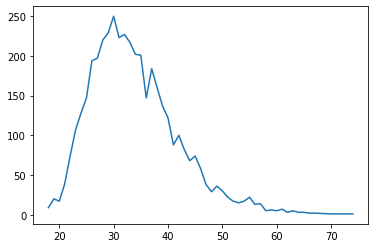

In [33]:
# Check age distribution of the respondents, which shows an expected gausssian distribution
osmi_df_clean['1'].value_counts().sort_index().plot()

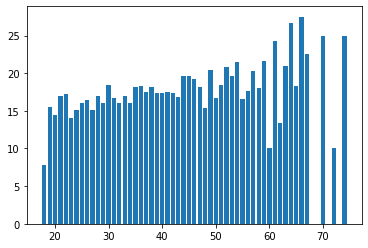

In [35]:
# Let's explore the Mental Health score across the age
from matplotlib import pyplot as plt
vc = osmi_df_clean.groupby('1').MH_Score.mean().sort_index()
fig, ax = plt.subplots()
plt.bar(vc.index, vc.values)
plt.show()

In [36]:
# Checking amount of missing values in the reduced dataset
osmi_df_clean.isna().sum()/nusers*100

UserID       0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
              ...    
83          63.845424
85          63.845424
88          63.845424
89          63.845424
MH_Score     0.000000
Length: 96, dtype: float64

In [37]:
# We drop 95 and 96 as they are not relevant to our queries and have more than 70% NA records
#'95', 'Has your employer ever discussed mental health as part of an employee wellness program?'
#'96', 'Does your employer provide resources to learn more about mental health issues and how to seek help?'
osmi_df_clean.drop(columns = ['95','96'], inplace=True)

### Stage 5: Modelling and Visualization of the Data

### Let's look at our first question: 
#### 1. Are people working in Tech reporting higher mental health issues than non-Tech workers?
##### Columns of interest is as following while imputing NAs with the values of the other columns in that order
##### '13', 'Is your primary role within your company related to tech/IT?' (Most important factor to determine if a person works in Tech)
##### '68', 'Was your employer primarily a tech company/organization?' (Second most important factor to determine if a person works in Tech)
##### '9', 'Is your employer primarily a tech company/organization?' (Last factor to determine if a person works in Tech in case it is missing in above fields)

In [38]:
# There are approx 30% missing values for '13'
osmi_df_clean['13'].isna().sum()/nusers, osmi_df_clean['13'].isna().sum()

(0.29871977240398295, 1260)

In [39]:
# There are no additional records in '68' which can help impute values for '13' hence dropping '68'
osmi_df_clean[osmi_df_clean['13'].isna() & ~osmi_df_clean['68'].isna()]

,UserID,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,83,85,88,89,MH_Score


In [40]:
osmi_df_clean.drop(columns=['68'], inplace=True)

In [41]:
# All missing values of '13' can be imputed from '9' since '9' does not have any missing values
osmi_df_clean[osmi_df_clean['13'].isna() & ~osmi_df_clean['9'].isna()]

,UserID,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,83,85,88,89,MH_Score
0,1,37,Female,United States,Illinois,-1,No,1,6-25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
1,2,44,Male,United States,Indiana,-1,No,0,More than 1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,32,Male,Canada,-1,-1,No,0,6-25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4,31,Male,United Kingdom,-1,-1,Yes,1,26-100,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
4,5,31,Male,United States,Texas,-1,No,0,100-500,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,1256,32,Male,United States,Illinois,0,Yes,1,26-100,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
1256,1257,34,Male,United States,California,0,Yes,1,More than 1000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
1257,1258,46,Female,United States,North Carolina,0,No,0,100-500,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1258,1259,25,Male,United States,Illinois,0,Yes,1,26-100,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [42]:
# Updating missing values of '13' with responses from '9' 
osmi_df_clean.loc[osmi_df_clean['13'].isna() & ~osmi_df_clean['9'].isna(), '13']=osmi_df_clean[osmi_df_clean['13'].isna() & ~osmi_df_clean['9'].isna()]['9']

In [43]:
osmi_df_clean['13'].isna().sum()

0

In [44]:
# We can drop '9' now
osmi_df_clean.drop(columns=['9'], inplace=True)

In [45]:
# Some responses for '13' are 0, which is non intutive and hence we remove those rows from our analysis
osmi_df_clean['13'].value_counts()

 1.0    2502
-1.0    1387
 0.0     329
Name: 13, dtype: int64

In [46]:
techwork_osmi = osmi_df_clean[osmi_df_clean['13']!=0.0]

In [47]:
techwork_osmi['13'].value_counts()

 1.0    2502
-1.0    1387
Name: 13, dtype: int64

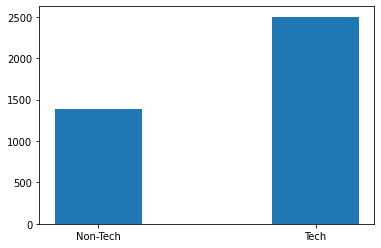

In [48]:
from matplotlib import pyplot as plt
# Distribution of responses between people with Tech and non Tech work shows that there are almost double Tech responses
# than non-Tech responses
vc = techwork_osmi['13'].value_counts()
#
fig, ax = plt.subplots()
plt.bar(vc.index, vc.values)
plt.xticks(vc.index, ('Tech', 'Non-Tech'))
plt.show()

In [49]:
# Calculating the %age of people with positive MH_socre and the mean within the two categories
MH_per = round(techwork_osmi[techwork_osmi['MH_Score']>0].groupby('13')['UserID'].count()/techwork_osmi.groupby('13')['UserID'].count()*100,2)
MH_per

13
-1.0    98.05
 1.0    76.10
Name: UserID, dtype: float64

In [50]:
MH_mean = round(techwork_osmi[techwork_osmi['MH_Score']>0].groupby('13')['MH_Score'].mean(),2)
MH_mean

13
-1.0    23.08
 1.0    19.19
Name: MH_Score, dtype: float64

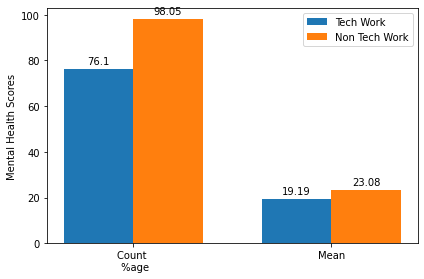

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Count \n %age', 'Mean']
non_tech_vals = [MH_per.values[0], MH_mean.values[0]]
tech_vals = [MH_per.values[1], MH_mean.values[1]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, tech_vals, width, label='Tech Work')
rects2 = ax.bar(x + width/2, non_tech_vals, width, label='Non Tech Work')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mental Health Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.savefig('images/TechMH.jpg')
plt.show()


### Now let's explore the second question
#### 2. Do people working in smaller organizations have better or worse mental health than those working in larger organizations

In [52]:
#Removing rows with invalid value of -1
osmi_df_8 = osmi_df_clean[osmi_df_clean['8']!='-1']
osmi_df_8['8'].value_counts()

More than 1000    912
26-100            824
100-500           788
6-25              689
1-5               254
500-1000          247
Name: 8, dtype: int64

In [53]:
vc = round(osmi_df_8.groupby('8')['MH_Score'].mean(),2)
vc

8
1-5               13.52
100-500           17.88
26-100            15.78
500-1000          17.19
6-25              14.99
More than 1000    16.83
Name: MH_Score, dtype: float64

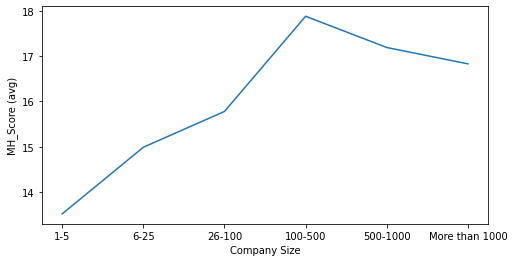

In [54]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8,4))
cats_vals = [vc[0],vc[4],vc[2],vc[1],vc[3],vc[5]]
cats = [vc.index[0],vc.index[4],vc.index[2],vc.index[1],vc.index[3],vc.index[5]]

plt.plot(cats, cats_vals)
#plt.xticks(vc.index, ('Tech', 'Non-Tech'))
plt.xlabel("Company Size")
plt.ylabel("MH_Score (avg)")
plt.savefig('images/Comp_size.jpg')
plt.show()

### Lets look at the responses to the below questions to understand this better
#### '10': 'Does your employer provide mental health benefits as part of healthcare coverage?'
 

In [55]:
#'10','Does your employer provide mental health benefits as part of healthcare coverage?'
vc = osmi_df_8[osmi_df_8['10']=='Yes']['8'].value_counts()/osmi_df_8['8'].value_counts()*100

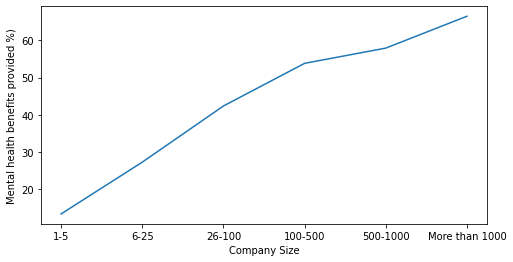

In [56]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8,4))
cats_vals = [vc[0],vc[4],vc[2],vc[1],vc[3],vc[5]]
cats = [vc.index[0],vc.index[4],vc.index[2],vc.index[1],vc.index[3],vc.index[5]]

plt.plot(cats, cats_vals)
#plt.xticks(vc.index, ('Tech', 'Non-Tech'))
plt.xlabel("Company Size")
plt.ylabel("Mental health benefits provided %)")
plt.savefig('images/MH_Benefits.jpg')
plt.show()

### Now to the last question:
#### 3. What type of role do people with mental health issues have?

In [69]:
#'117', 'Which of the following best describes your work position?'
osmi_df_clean['117'].isna().sum()/nusers*100

66.02655286865813

In [70]:
# Even though we have significant amount of missing values, we can still try to derive some insights from the remaining records
osmi_df_117 = osmi_df_clean.dropna(subset=['117'])

In [71]:
vc = osmi_df_117['117'].value_counts()

In [72]:
# Find unique roles within '117'. The column may have multiple roles seperated by comma
job=set()
for i in [x.split(', ') for x in osmi_df_117['117'].unique()]:
    for j in i:
        job.add(j)

In [73]:
# Check the unique roles
job

{'Back-end Developer',
 'Designer',
 'Dev Evangelist/Advocate',
 'DevOps/SysAdmin',
 'Executive Leadership',
 'Front-end Developer',
 'HR',
 'One-person shop',
 'Other',
 'Sales',
 'Supervisor/Team Lead',
 'Support'}

In [74]:
#Create new columns for each of the unique roles in the dataframe
pd.set_option('mode.chained_assignment', None)
for j in job:
    osmi_df_117[j]=0

In [75]:
#Update newly created columns with 1 if that person performs that role or keep it set to 0 otherwise
for row in osmi_df_117.iloc:
    userid = row.UserID
    jobs = row['117']
    job = jobs.split(', ')
    for j in job:
        osmi_df_117.loc[osmi_df_117.UserID==userid, j]=1
    

In [76]:
# Make a copy of the dataframe with columns related to job role and MH_Score only
osmi_df_jobs = osmi_df_117[['Supervisor/Team Lead', 'DevOps/SysAdmin', 'Other',
       'Front-end Developer', 'HR', 'Back-end Developer',
       'Dev Evangelist/Advocate', 'One-person shop', 'Executive Leadership',
       'Sales', 'Support', 'Designer', 'MH_Score']]

In [77]:
osmi_df_jobs= osmi_df_jobs[osmi_df_jobs['MH_Score']>0].drop(columns='MH_Score')
df = osmi_df_jobs.melt(value_vars=osmi_df_jobs.columns)
df = df.groupby('variable').sum()

In [78]:
df = df.reset_index()

In [79]:
df = df.sort_values(by='value')

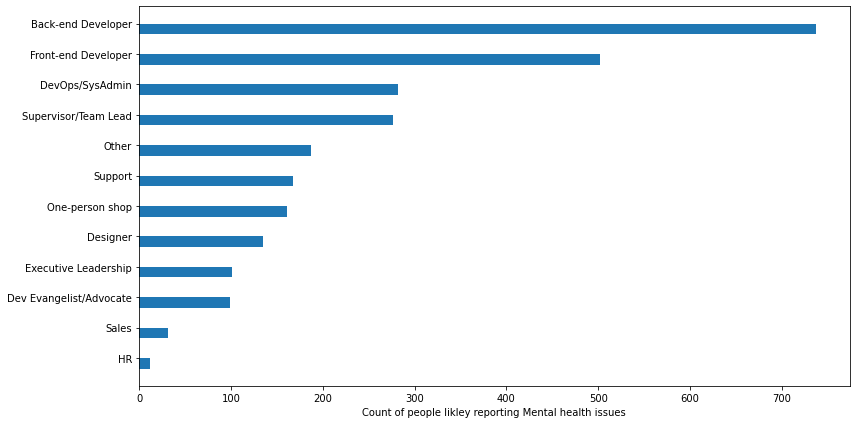

In [80]:
# Create a horizontal bar chart to see the different roles reporting mental health issues
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = df.variable
tech_vals = df.value

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (12,6))
rects1 = ax.barh(x - width/2, tech_vals, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Count of people likley reporting Mental health issues')
ax.set_yticks(x)
ax.set_yticklabels(labels)

fig.tight_layout()

plt.savefig('images/JobType.jpg')
plt.show()